In [1]:
from __future__ import division
import numpy as np
import scipy.optimize as opt
from scipy import interpolate as itp
%pylab inline

data_dir = '../data/'

#-------------------------------------------------------------------------------------------------------------------------
# Define some utilities
#-------------------------------------------------------------------------------------------------------------------------
# Align data to origin
align = lambda x : x - np.repeat(x[:,0],np.shape(x)[1]).reshape(np.shape(x))
# Normalize data w.r.t to maximum
normalize = lambda x : (x-x.min())/(x.max()-x.min())
# Define max / min difference
rdata = lambda x : np.amax(x)-np.amin()

def unique_rows(a,col=0):
    """ 
    Find unique rows of a matrix a and sort according to elements in column col
    """
    b = np.ascontiguousarray(a).view(np.dtype((np.void, a.dtype.itemsize * a.shape[1])))
    _, idx = np.unique(b, return_index=True)
    # a = a[idx]
    # Retrieve complementary index to be dumped 
    idxc = tuple(set(range(np.size(b)))-set(idx))
    a = np.delete(a,idxc,axis=0)
    if col==None:
        return a
    else:
        return a[a[:,col].argsort(),]

def interx(L1,*args):
    """
    Python equivalent of MATLAB interx() function.
    Fast finder of all intersections of 2D curves.
    
    Use:
    P = interx(L1)
    P = interx(L1,L2)
    
    Inputs:
    - LX : [[x0,...,xN],[y1,...,yN]] coordinates of the X=1,2 curve
    
    Output:
    - P  : coordinates of intersections [[px0,...pxN],[py0,...,pyN]]
    
    Maurizio De Pitta', The University of Chicago, March 31st, 2015.
    """
    if not args:
        L2 = L1
        hF = lambda x : np.less(x,zeros(1))
    else:
        L2 = args[0]
        hF = lambda x : np.less_equal(x,zeros(1))
    
    D = lambda x,y : (x[:,:-1]-y)*(x[:,1:]-y)

    
    # Preliminary stuff
    x1 = L1[0,:].T[:,None]
    y1 = L1[1,:].T[:,None]
    x2 = L2[0,:]
    y2 = L2[1,:]
    dx1 = np.diff(x1,axis=0)
    dx2 = np.diff(x2)
    dy1 = np.diff(y1,axis=0)
    dy2 = np.diff(y2)
    
    # Determine 'signed distances'
    S1 = dx1*y1[:-1] - dy1*x1[:-1]
    S2 = dx2*y2[:-1] - dy2*x2[:-1]
    
    C1 = hF(D(dx1*y2-dy1*x2,S1))
    C2 = hF(D(np.transpose(y1*dx2-x1*dy2),S2.T[:,None])).T

    # Obtain the segments where an intersection is expected
    [i,j] = np.where(np.logical_and(C1,C2)) #To check    
    if not np.size(i):
        return np.zeros((0,1))

    # Prepare for output
    dx2 = dx2.T[:,None]
    dy2 = dy2.T[:,None]
    S2 = S2.T[:,None]
    L = dy2[j]*dx1[i] - dy1[i]*dx2[j]
    i = i[~np.equal(L,0.0).reshape((size(L)))]
    j = j[~np.equal(L,0.0).reshape((size(L)))]
    L = L[~np.equal(L,0.0).reshape((size(L)))]
    
    aux = np.hstack((dx2[j]*S1[i]-dx1[i]*S2[j],dy2[j]*S1[i]-dy1[i]*S2[j]))/np.hstack((L,L))
    P = unique_rows(aux).T

    return P

def bi_exp(x,tr,td):
    # Bi-exponential curve
    tx = tr*td/(td-tr)
    C = 1.0/((tr/td)**(tx/td)-(tr/td)**(tx/tr))
    return np.asarray(C*(np.exp(-x/td)-np.exp(-x/tr)))

def objective(tau,x,y):
    # Assumes that the traces are normalized
    tr = tau[0]
    td = tau[1]
    tx = tr*td/(td-tr)
    C = 1.0/((tr/td)**(tx/td)-(tr/td)**(tx/tr))
    f =  np.asarray(C*(np.exp(-x/td)-np.exp(-x/tr)))
    return np.sum((f-y)**2)

def linear_fun(x,ts,k):
    # Linear curve
    return k*x + ts

def objective_linear(tpar,x,y):
    ts = tpar[0]
    k = tpar[1]
    f = linear_fun(x,ts,k)
    return np.sum((f-y)**2)

def exp_fun(x,xmax,rate):
    # Monoexponential curve
    return xmax*(1.0-np.exp(-rate*x))

def objective_exp(pars,x,y):
    xmax = pars[0]
    rate = pars[1]
    f = exp_fun(x,xmax,rate)
    return np.sum((f-y)**2)

def biexp_linear(tr,td,xmax):
    # Linear approximation of bi-exponential curve
    tx = tr*td/(td-tr)
    C = 1.0/((tr/td)**(tx/td)-(tr/td)**(tx/tr))
    return xmax*C*(1./tr-1./td)

Populating the interactive namespace from numpy and matplotlib


In [404]:
#-------------------------------------------------------------------------------------------------------------------------
# Estimation of Ca2+ propagation speeds from Di Castro et al., Nature Neurosci. 2011; Figure S5  
#-------------------------------------------------------------------------------------------------------------------------
# Data from DiCastro by WebPlot Digitalizer
data = [508.5 , -3.0,
        1111.6,  9.8,
        2129.9,  8.1,
        2398.9,  9.2,
        2129.9,  8.1,
        2677.3, -2.3,
        3836.7,  8.6,
        4034.0,  9.7,
        3836.7,  8.6,
        4146.8,  1.7,
        3951.8, -2.9,
        4146.8,  1.7]
data = np.diff(np.asarray(data,dtype=float).reshape((12,2)),axis=0)
time = np.abs(data[::2,0])
space = np.abs(data[::2,1])
speed = space/time
print "Speed (um/s): ",np.mean(speed)*1e3,"+/-",np.std(speed)*1e3 # provided in um/s

Speed (um/s):  15.9546162331 +/- 7.99465906888


In [2]:
#-------------------------------------------------------------------------------------------------------------------------
# Estimation of Ca2+ dynamics in microglia from Brawek et al.'s data in vivo (Sci. Rep. 2017, Cell Calcium 2017)
#-------------------------------------------------------------------------------------------------------------------------
# Generate traces
filename = ['Brawek_SR2017_'] * 3
traces = [None] * 3
for i in range(3):
    traces[i] = align(numpy.loadtxt(open(data_dir+filename[i]+'tr'+str(i)+'.csv', "rb"), delimiter=",").T)
#     plot(traces[i][0],traces[i][1],'o')   
filename = ['Brawek_CC2017_'] * 3
traces_ = [None] * 3
for i in range(3):
    traces_[i] = align(numpy.loadtxt(open(data_dir+filename[i]+'tr'+str(i)+'.csv', "rb"), delimiter=",").T)    
# Join
traces = traces + traces_

npts = 20 # for interpolation
trise,tdecay,FWHM = np.zeros(6),np.zeros(6),np.zeros(6)
for i,tr in enumerate(traces):
    s = itp.UnivariateSpline(tr[0],tr[1],s=0.,k=1)
    time = np.linspace(tr[0,0],tr[0,-1],npts)
    ca = normalize(s(time))
    # Estimate rise and decay times
    sol = opt.differential_evolution(objective,bounds=((0.5,3.0),(5.0,25.)),
                                     args=(time,ca),tol=1e-3,popsize=200,strategy='rand1bin')
    print "[t_r,t_d] : ",sol.x,sol.success,sol.message
    if sol.success:
        trise[i]  = sol.x[0]
        tdecay[i] = sol.x[1]
    # Estimate FWHM
    P = interx(np.asarray([time,ca]),np.asarray([time[[0,-1]],[0.5,0.5]]))
    FWHM[i] = np.diff(P[0])
    print "FWHM : ",FWHM[i]  
    # Check results
    plot(tr[0],normalize(tr[1]),'.',
         time,bi_exp(time,sol.x[0],sol.x[1]),'-')

# Plot final results
ndec = 1
print "t_rise: ",np.round(np.mean(trise),ndec),"+/-",np.round(np.std(trise),ndec),"\trange: ",np.around([np.mean(trise)-np.std(trise),np.mean(trise)+np.std(trise)],ndec)
print "t_decay: ",np.round(np.mean(tdecay),ndec),"+/-",np.round(np.std(tdecay),ndec),"\trange: ",np.around([np.mean(tdecay)-np.std(tdecay),np.mean(tdecay)+np.std(tdecay)],ndec)
print "FWHM: "  ,np.round(np.mean(FWHM),ndec),"+/-",np.round(np.std(FWHM),ndec),"\trange: ",np.around([np.mean(FWHM)-np.std(FWHM),np.mean(FWHM)+np.std(FWHM)],ndec)

NameError: name 'npts' is not defined

[t_r,t_d] :  [ 7.48637133  7.49320452] True Optimization terminated successfully.
FHWM :  15.3121377846
[t_r,t_d] :  [ 7.73665345  7.73157842] True Optimization terminated successfully.
FHWM :  15.5798990476
[t_r,t_d] :  [ 7.22029488  7.22894254] True Optimization terminated successfully.
FHWM :  16.0335307068
[t_r,t_d] :  [ 6.92926195  6.9307544 ] True Optimization terminated successfully.
FHWM :  14.2653837135
[t_r,t_d] :  [ 7.57345273  7.56732227] True Optimization terminated successfully.
FHWM :  15.1410453144
[t_r,t_d] :  [ 6.52342191  6.52410153] True Optimization terminated successfully.
FHWM :  13.6974174114
[t_r,t_d] :  [ 8.02218309  8.03190756] True Optimization terminated successfully.
FHWM :  16.5858798065
[t_r,t_d] :  [ 6.49161897  6.49185421] True Optimization terminated successfully.
FHWM :  13.7694884171
[t_r,t_d] :  [ 6.81807003  6.81617066] True Optimization terminated successfully.
FHWM :  14.2497077163
[t_r,t_d] :  [ 7.98075323  7.97471174] True Optimization termina

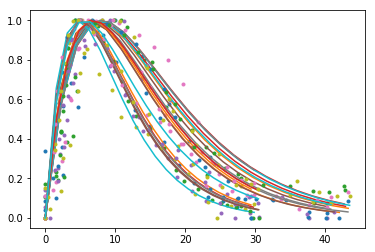

In [428]:
#-------------------------------------------------------------------------------------------------------------------------
# Estimation of Ca2+ dynamics in oligodendrocytes from James et al.'s data in situ (Cell Calcium, 2001)
#-------------------------------------------------------------------------------------------------------------------------
# Generate traces
ntraces = 20
filename = ['James_CC2001_'] * ntraces
traces = [None] * ntraces
for i in range(ntraces):
    traces[i] = numpy.loadtxt(open(data_dir+filename[i]+'tr'+str(i)+'.csv', "rb"), delimiter=",").T
    # Sorting by ascending x values
    idx = traces[i][0].argsort()
    traces[i][0] = traces[i][0][idx]
    traces[i][1] = traces[i][1][idx]
    traces[i] = align(traces[i])
    # Intermediate check
#     plot(traces[i][0],traces[i][1],'o')   

trise,tdecay,FWHM = np.zeros(ntraces),np.zeros(ntraces),np.zeros(ntraces)
for i,tr in enumerate(traces):
    s = itp.UnivariateSpline(tr[0],tr[1],s=0.,k=1)
    time = np.linspace(tr[0,0],tr[0,-1],npts)
    ca = normalize(s(time))
    
    # Estimate rise and decay times
    sol = opt.differential_evolution(objective,bounds=((2.0,9.0),(4.0,25.)),
                                     args=(time,ca),tol=1e-3,popsize=200,strategy='rand1bin')
    print "[t_r,t_d] : ",sol.x,sol.success,sol.message
    if sol.success:
        trise[i]  = sol.x[0]
        tdecay[i] = sol.x[1]
    # Estimate FWHM
    P = interx(np.asarray([time,ca]),np.asarray([time[[0,-1]],[0.5,0.5]]))
    FWHM[i] = np.diff(P[0])
    print "FHWM : ",FWHM[i]  
    # Check results
    plot(tr[0],normalize(tr[1]),'.',
         time,bi_exp(time,sol.x[0],sol.x[1]),'-')

# Plot final results
ndec = 1
print "t_rise: ",np.round(np.mean(trise),ndec),"+/-",np.round(np.std(trise),ndec),"\trange: ",np.around([np.mean(trise)-np.std(trise),np.mean(trise)+np.std(trise)],ndec)
print "t_decay: ",np.round(np.mean(tdecay),ndec),"+/-",np.round(np.std(tdecay),ndec),"\trange: ",np.around([np.mean(tdecay)-np.std(tdecay),np.mean(tdecay)+np.std(tdecay)],ndec)
print "FWHM: "  ,np.round(np.mean(FWHM),ndec),"+/-",np.round(np.std(FWHM),ndec),"\trange: ",np.around([np.mean(FWHM)-np.std(FWHM),np.mean(FWHM)+np.std(FWHM)],ndec)

[t_r,t_d] :  [ 0.16314687  5.86840986] True Optimization terminated successfully.
[t_r,t_d] :  [ 0.05        6.65208552] True Optimization terminated successfully.
[t_r,t_d] :  [ 28.29116131  74.33590994] True Optimization terminated successfully.
[t_r,t_d] :  [  6.22811666  95.72253524] True Optimization terminated successfully.
[t_r,t_d] :  [ 18.72212558  18.72250689] True Optimization terminated successfully.
t_rise range (Covelo):  0.0 0.2
t_rise range (Perea):  6.2 28.3
t_decay range (Covelo):  5.9 6.7
t_decay range (Perea):  18.7 95.7


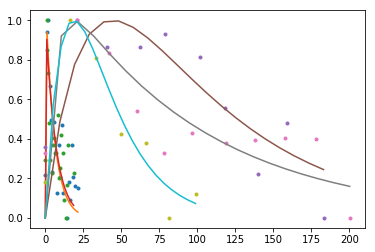

In [511]:
#-------------------------------------------------------------------------------------------------------------------------
# Estimation of Pr(Glu) from Covelo et al.'s data in situ (eLife, 2018)
#-------------------------------------------------------------------------------------------------------------------------
# Generate traces
ntraces = 2
filename = ['Covelo_eL2018_'] * ntraces
traces = [None] * ntraces
for i in range(ntraces):
    traces[i] = numpy.loadtxt(open(data_dir+filename[i]+'glu'+str(i)+'.csv', "rb"), delimiter=",").T
    # Sorting by ascending x values
    idx = traces[i][0].argsort()
    traces[i][0] = traces[i][0][idx]
    traces[i][1] = traces[i][1][idx]
    traces[i] = align(traces[i])

filename = ['Perea_Science2007_'] * 3
traces_ = [None] * 3
for i in range(3):
    traces_[i] = numpy.loadtxt(open(data_dir+filename[i]+'pr'+str(i)+'.csv', "rb"), delimiter=",").T
    # Sorting by ascending x values
    idx = traces_[i][0].argsort()
    traces_[i][0] = traces_[i][0][idx]
    traces_[i][1] = traces_[i][1][idx]
    traces_[i] = align(traces_[i])
# Join
traces = traces + traces_

# for i,tr in enumerate(traces):
#     if i>3:
#         plot(tr[0],tr[1],'-')

npts = 20
trise,tdecay = np.zeros(len(traces)),np.zeros(len(traces))
for i,tr in enumerate(traces):
    s = itp.UnivariateSpline(tr[0],tr[1],s=0.,k=1)
    time = np.linspace(tr[0,0],tr[0,-1],npts)
    ca = normalize(s(time))
    
    # Estimate rise and decay times
    if i<2:
        bounds = ((0.05,0.5),(1.0,10.))
    else:
        bounds = ((5.,30.0),(15.0,100.0))  # Perea and Araque (2007) ()
    sol = opt.differential_evolution(objective,bounds=bounds,
                                     args=(time,ca),tol=1e-5,popsize=400,strategy='rand1bin')
    print "[t_r,t_d] : ",sol.x,sol.success,sol.message
    if sol.success:
        trise[i]  = sol.x[0]
        tdecay[i] = sol.x[1]
    # Check results
    plot(tr[0],normalize(tr[1]),'.',
         time,bi_exp(time,sol.x[0],sol.x[1]),'-')

# Plot final results
ndec = 1
print "t_rise range (Covelo): " ,np.round(np.amin(trise[[0,1]]),ndec),np.round(np.amax(trise[[0,1]]),ndec)
print "t_rise range (Perea): "  ,np.round(np.amin(trise[[2,3,4]]),ndec),np.round(np.amax(trise[[2,3,4]]),ndec)
print "t_decay range (Covelo): ",np.round(np.amin(tdecay[[0,1]]),ndec),np.round(np.amax(tdecay[[0,1]]),ndec)
print "t_decay range (Perea): " ,np.round(np.amin(tdecay[[2,3,4]]),ndec),np.round(np.amax(tdecay[[2,3,4]]),ndec)

[t_r,t_d] :  [ 8.21338697  8.21064873] True Optimization terminated successfully.
[t_r,t_d] :  [  1.58539391  11.96603455] True Optimization terminated successfully.
t_rise range (Covelo/ATP):  1.6 8.2
t_decay range (Covelo/ATP):  8.2 12.0


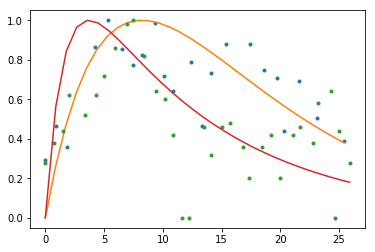

In [482]:
#-------------------------------------------------------------------------------------------------------------------------
# Estimation of Pr(ATP) from Covelo et al.'s data in situ (eLife, 2018)
#-------------------------------------------------------------------------------------------------------------------------
# Generate traces
ntraces = 2
filename = ['Covelo_eL2018_'] * ntraces
traces = [None] * ntraces
for i in range(ntraces):
    traces[i] = numpy.loadtxt(open(data_dir+filename[i]+'atp'+str(i)+'.csv', "rb"), delimiter=",").T
    # Sorting by ascending x values
    idx = traces[i][0].argsort()
    traces[i][0] = traces[i][0][idx]
    # Because these data points are negative flip them by x-axis
    traces[i][1] = -traces[i][1][idx]
    traces[i] = align(traces[i])
    
npts = 30
trise,tdecay = np.zeros(len(traces)),np.zeros(len(traces))
for i,tr in enumerate(traces):
    s = itp.UnivariateSpline(tr[0],tr[1],s=0.1,k=3)
    time = np.linspace(tr[0,0],tr[0,-1],npts)
    ca = normalize(s(time))
    
    # Estimate rise and decay times
    bounds = ((0.1,10.0),(5.0,20.))
    sol = opt.differential_evolution(objective,bounds=bounds,
                                     args=(time,ca),tol=1e-4,popsize=500,strategy='rand1bin')
    print "[t_r,t_d] : ",sol.x,sol.success,sol.message
    if sol.success:
        trise[i]  = sol.x[0]
        tdecay[i] = sol.x[1]
    # Check results
    plot(tr[0],normalize(tr[1]),'.',
         time,bi_exp(time,sol.x[0],sol.x[1]),'-')

# Plot final results
ndec = 1
print "t_rise range (Covelo/ATP): " ,np.round(np.amin(trise[[0,1]]),ndec),np.round(np.amax(trise[[0,1]]),ndec)
print "t_decay range (Covelo/ATP): ",np.round(np.amin(tdecay[[0,1]]),ndec),np.round(np.amax(tdecay[[0,1]]),ndec)

[ts,k] :  [-3.54668452  3.99997113] True Optimization terminated successfully.
[ts,k] :  [-2.61387122  0.30102444] True Optimization terminated successfully.
t_decay range (Perea):  0.3 4.0
Rate range:  0.3 4.0


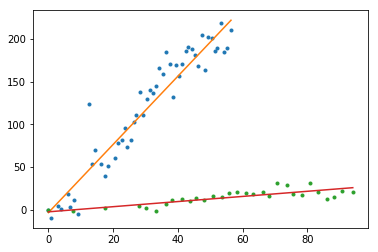

In [508]:
#-------------------------------------------------------------------------------------------------------------------------
# Estimation of LTP by D-serine from Takata et al. (JN 2011) and Young et al. (PNAS 2003)
#-------------------------------------------------------------------------------------------------------------------------
# Generate traces
ntraces = 2
filename = ['Young_PNAS2003','Takata_JN2011']
traces = [None] * ntraces
for i in range(ntraces):
    traces[i] = numpy.loadtxt(open(data_dir+filename[i]+'_dser.csv', "rb"), delimiter=",").T
    # Sorting by ascending x values
    idx = traces[i][0].argsort()
    traces[i][0] = traces[i][0][idx]
    traces[i][1] = traces[i][1][idx]
    traces[i] = align(traces[i])

# # Intermediate check of results
# for i,tr in enumerate(traces):
#     plot(tr[0],tr[1],'-')

rate = np.zeros(len(traces))
for i,tr in enumerate(traces):
    s = itp.UnivariateSpline(tr[0],tr[1],s=0.,k=1)
    time = np.linspace(tr[0,0],tr[0,-1],npts)
    data = s(time)
#     data = normalize(s(time))
    
    # Estimate rise and decay times
    bounds = ((-5.,5.),(0.01,30.0))
    sol = opt.differential_evolution(objective_linear,bounds=bounds,
                                     args=(time,data),tol=1e-4,popsize=200,strategy='rand1bin')
    print "[ts,k] : ",sol.x,sol.success,sol.message
    if sol.success:
        rate[i]  = sol.x[1]
    # Check results
#     plot(tr[0],normalize(tr[1]),'.',
    plot(tr[0],tr[1],'.',     
         time,linear_fun(time,sol.x[0],sol.x[1]),'-')

# Plot final results
ndec = 1
print "t_decay range (Perea): " ,np.round(np.amin(rate),ndec),np.round(np.amax(rate),ndec)
print "Rate range: " ,np.round(np.amin(rate),ndec),np.round(np.amax(rate),ndec)

[max,rate] :  [ 0.504       0.07888649] True Optimization terminated successfully.
xmax:  0.5
rate:  0.08


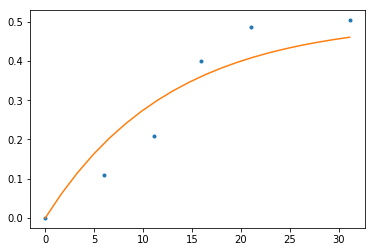

In [522]:
#-------------------------------------------------------------------------------------------------------------------------
# Process motility rate from Perez-Alvarez et al. (JN 2014)
#-------------------------------------------------------------------------------------------------------------------------
# Generate traces
ntraces = 1
filename = ['PAlvarez_JN2014']
traces = [None] * ntraces
for i in range(ntraces):
    traces[i] = numpy.loadtxt(open(data_dir+filename[i]+'_proc.csv', "rb"), delimiter=",").T
    # Sorting by ascending x values
    idx = traces[i][0].argsort()
    traces[i][0] = traces[i][0][idx]
    traces[i][1] = traces[i][1][idx]
    # Because these data points are negative flip them by x-axis
    traces[i] = align(traces[i])

# # Intermediate check of results
# for i,tr in enumerate(traces):
#     plot(tr[0],tr[1],'-')

xmax,rate = np.zeros(len(traces)),np.zeros(len(traces))
for i,tr in enumerate(traces):
    s = itp.UnivariateSpline(tr[0],tr[1],s=0.,k=1)
    time = np.linspace(tr[0,0],tr[0,-1],npts)
    data = s(time)
#     data = normalize(s(time))
    
    # Estimate rise and decay times
    bounds = ((0.4,np.amax(data)),(0.01,0.1))
    sol = opt.differential_evolution(objective_exp,bounds=bounds,
                                     args=(time,data),tol=1e-4,popsize=300,strategy='rand1bin')
    print "[max,rate] : ",sol.x,sol.success,sol.message
    if sol.success:
        xmax[i] = sol.x[0]
        rate[i] = sol.x[1]
    # Check results
#     plot(tr[0],normalize(tr[1]),'.',
    plot(tr[0],tr[1],'.',     
         time,exp_fun(time,sol.x[0],sol.x[1]),'-')

# Plot final results
ndec = 1
print "xmax: " ,np.round(sol.x[0],1)
print "rate: " ,np.round(sol.x[1],2)

[ts,k] :  [ 19.12399117   0.08000042] True Optimization terminated successfully.
xmax:  19.1
rate:  0.08


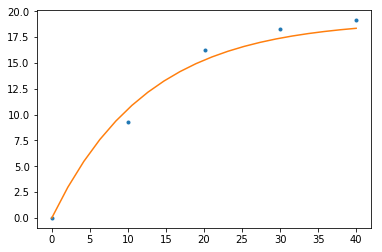

In [524]:
#-------------------------------------------------------------------------------------------------------------------------
# Estimation of % Area change by HCO3 from Florence et al. (PLoS One 2012)
#-------------------------------------------------------------------------------------------------------------------------
# Generate traces
ntraces = 1
filename = ['Florence_POne2012']
traces = [None] * ntraces
for i in range(ntraces):
    traces[i] = numpy.loadtxt(open(data_dir+filename[i]+'_volume.csv', "rb"), delimiter=",").T
    # Sorting by ascending x values
    idx = traces[i][0].argsort()
    traces[i][0] = traces[i][0][idx]
    traces[i][1] = traces[i][1][idx]
    traces[i] = align(traces[i])

# # Intermediate check of results
# for i,tr in enumerate(traces):
#     plot(tr[0],tr[1],'-')

rate = np.zeros(len(traces))
for i,tr in enumerate(traces):
    s = itp.UnivariateSpline(tr[0],tr[1],s=0.,k=1)
    time = np.linspace(tr[0,0],tr[0,-1],npts)
    data = s(time)
#     data = normalize(s(time))
    
    # Estimate rise and decay times
    bounds = ((0.4,np.amax(data)),(0.08,0.5))
    sol = opt.differential_evolution(objective_exp,bounds=bounds,
                                     args=(time,data),tol=1e-4,popsize=200,strategy='rand1bin')
    print "[ts,k] : ",sol.x,sol.success,sol.message
    if sol.success:
        xmax[i] = sol.x[0]
        rate[i] = sol.x[1]
    # Check results
#     plot(tr[0],normalize(tr[1]),'.',
    plot(tr[0],tr[1],'.',     
         time,exp_fun(time,sol.x[0],sol.x[1]),'-')

# Plot final results
ndec = 1
print "xmax: " ,np.round(sol.x[0],1)
print "rate: " ,np.round(sol.x[1],2)

rate:  0.681211942882 True Optimization terminated successfully.
t_d:  0.0819811298841 True Optimization terminated successfully.
rate:  0.348589366435 True Optimization terminated successfully.
t_d:  0.0888517561768 True Optimization terminated successfully.
Stimulus-depedendent rate change range:  0.3 0.7
t_decay range:  0.1 0.1


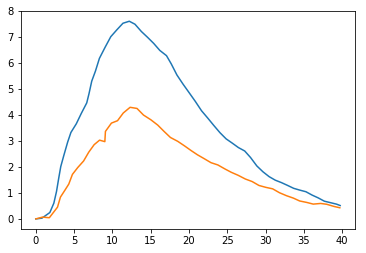

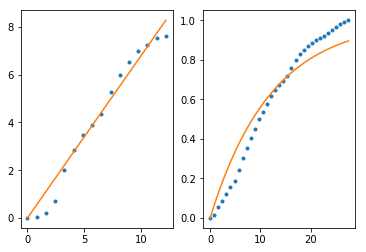

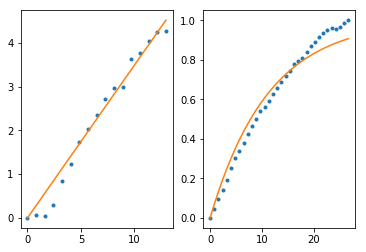

In [539]:
#-------------------------------------------------------------------------------------------------------------------------
# Estimation of % ECS shrinkage from Larsen et al. (Glia, 2014)
#-------------------------------------------------------------------------------------------------------------------------
# Generate traces
ntraces = 2
filename = ['Larsen_Glia2014_'] * ntraces
traces = [None] * ntraces
for i in range(ntraces):
    traces[i] = numpy.loadtxt(open(data_dir+filename[i]+'volume'+str(i)+'.csv', "rb"), delimiter=",").T
    # Sorting by ascending x values
    idx = traces[i][0].argsort()
    traces[i][0] = traces[i][0][idx]
    # Because these data points are negative flip them by x-axis
    traces[i][1] = -traces[i][1][idx]
    traces[i] = align(traces[i])

# Intermediate check of results
for i,tr in enumerate(traces):
    plot(tr[0],tr[1],'-')    
    
npts = 50
rate,tdecay = np.zeros(len(traces)),np.zeros(len(traces))
for i,tr in enumerate(traces):
    s = itp.UnivariateSpline(tr[0],tr[1],s=0.,k=1)
    time = np.linspace(tr[0,0],tr[0,-1],npts)
    data = s(time)
    index = np.argmax(data)
    data_n = normalize(data[index:]) # Decay only
    data_n = data_n[0]-data_n
    data = data[:index+1] # Rise only
    
    time_n = time[index:]-time[index]
    time = time[:index+1]
    
    # Estimate linear rising rate
    bounds = ((0.,2.0),(0.1,0.8))
    sol = opt.differential_evolution(objective_linear,bounds=bounds,
                                     args=(time,data),tol=1e-4,popsize=500,strategy='rand1bin')
    if sol.success:
        rate[i]  = sol.x[1]
        ts = sol.x[0]
    print "rate: ",sol.x[1],sol.success,sol.message
    
     # Estimate rise and decay times
    bounds = ((1.,1.),(0.01,0.2))
    sol = opt.differential_evolution(objective_exp,bounds=bounds,
                                     args=(time_n,data_n),tol=1e-4,popsize=500,strategy='rand1bin')
    if sol.success:
        tdecay[i] = sol.x[1]    
    print "t_d: ",sol.x[1],sol.success,sol.message
    
    # Check results
    _, (ax1, ax2) = subplots(1, 2)
    ax1.plot(time,data,'.',
             time,linear_fun(time,ts,rate[i]),'-')
    ax2.plot(time_n,data_n,'.',
             time_n,exp_fun(time_n,1.0,tdecay[i]),'-')

# Print final results
ndec = 1
print "Stimulus-depedendent rate change range: " ,np.round(np.amin(rate),ndec),np.round(np.amax(rate),ndec)
print "t_decay range: ",np.round(np.amin(tdecay),ndec),np.round(np.amax(tdecay),ndec)

[t_r,t_d] :  [ 0.9855321   0.98558834] True Optimization terminated successfully.
[t_r,t_d] :  [ 0.85982873  0.85978025] True Optimization terminated successfully.
[t_r,t_d] :  [ 0.97871605  0.97819108] True Optimization terminated successfully.
[t_r,t_d] :  [ 4.08277755  4.08212112] True Optimization terminated successfully.
[t_r,t_d] :  [ 4.92261325  4.92178767] True Optimization terminated successfully.
[t_r,t_d] :  [ 2.78821912  2.7882421 ] True Optimization terminated successfully.
t_rise:  2.4 +/- 1.6 	range:  0.9 4.9
t_decay:  2.4 +/- 1.6 	range:  0.9 4.9


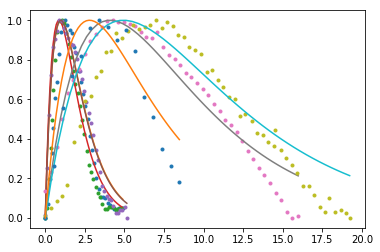

In [564]:
#-------------------------------------------------------------------------------------------------------------------------
# Estimation of extracellular K+ dynamics from Wang et al. (PNAS 2012, Science 2012)
#-------------------------------------------------------------------------------------------------------------------------
# Generate traces
nsets = 6
filename = ['Wang_Science2012_'] * nsets
traces = [None] * nsets
for i in range(nsets):
    traces[i] = numpy.loadtxt(open(data_dir+filename[i]+'tr'+str(i)+'.csv', "rb"), delimiter=",").T
    # Sorting by ascending x values
    idx = traces[i][0].argsort()
    traces[i][0] = traces[i][0][idx]
    # Because these data points are negative flip them by x-axis
    traces[i][1] = -traces[i][1][idx]
    traces[i] = align(traces[i])    
# Clean a trace that is not used
del traces[5]

nsets = 1
filename = ['Wang_PNAS2012_'] * 1
traces_ = [None] * nsets
for i in range(nsets):
    traces_[i] = numpy.loadtxt(open(data_dir+filename[i]+'tr'+str(i)+'.csv', "rb"), delimiter=",").T
    # Sorting by ascending x values
    idx = traces_[i][0].argsort()
    traces_[i][0] = traces_[i][0][idx]
    # Because these data points are negative flip them by x-axis
    traces_[i][1] = -traces_[i][1][idx]
    traces_[i] = align(traces_[i])    
# Join
traces = traces + traces_

# # Intermediate check of data
# for i,tr in enumerate(traces):
#     if i<7:
#         plot(tr[0],normalize(tr[1]),'-') 

trise,tdecay = np.zeros(len(traces)),np.zeros(len(traces))
for i,tr in enumerate(traces):
    s = itp.UnivariateSpline(tr[0],tr[1],s=0.,k=1)
    time = np.linspace(tr[0,0],tr[0,-1],npts)
    ca = normalize(s(time))
    # Estimate rise and decay times
    if i not in [3,4]:
        bounds = ((0.1,5.0),(0.1,3.))
    else:
        bounds = ((2.,5.0),(1.,15.))
    sol = opt.differential_evolution(objective,bounds=bounds,
                                     args=(time,ca),tol=1e-3,popsize=200,strategy='rand1bin')
    print "[t_r,t_d] : ",sol.x,sol.success,sol.message
    if sol.success:
        trise[i]  = sol.x[0]
        tdecay[i] = sol.x[1]
    # Check results
    plot(tr[0],normalize(tr[1]),'.',
         time,bi_exp(time,sol.x[0],sol.x[1]),'-')

# Plot final results
ndec = 1
print "t_rise: ",np.round(np.mean(trise),ndec),"+/-",np.round(np.std(trise),ndec),"\trange: ",np.round(np.amin(trise),ndec),np.round(np.amax(trise),ndec)
print "t_decay: ",np.round(np.mean(tdecay),ndec),"+/-",np.round(np.std(tdecay),ndec),"\trange: ",np.round(np.amin(tdecay),ndec),np.round(np.amax(tdecay),ndec)

[t_r,t_d] :  [ 5.17658191  5.17391121] True Optimization terminated successfully.
[t_r,t_d] :  [ 4.14255895  4.14393255] True Optimization terminated successfully.
t_rise:  4.7 +/- 0.5 	range:  4.1 5.2
t_decay:  4.7 +/- 0.5 	range:  4.1 5.2


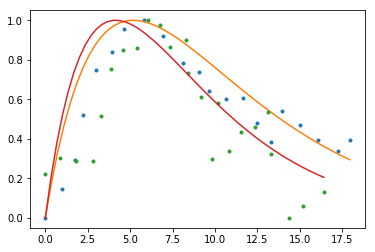

In [567]:
#-------------------------------------------------------------------------------------------------------------------------
# Estimation of Lactate production and degradation by NADPH fluorescence data in astrocytes by Gordon et al. (Nature 2008)
#-------------------------------------------------------------------------------------------------------------------------
# Generate traces
nsets = 2
filename = ['Gordon_Nature2008_'] * nsets
traces = [None] * nsets
for i in range(nsets):
    traces[i] = numpy.loadtxt(open(data_dir+filename[i]+'nadph'+str(i)+'.csv', "rb"), delimiter=",").T
    # Sorting by ascending x values
    idx = traces[i][0].argsort()
    traces[i][0] = traces[i][0][idx]
    traces_[i][1] = traces_[i][1][idx]
    traces[i] = align(traces[i])
    
# # Intermediate check of data
# for i,tr in enumerate(traces):
#     plot(tr[0],normalize(tr[1]),'-') 

trise,tdecay = np.zeros(len(traces)),np.zeros(len(traces))
for i,tr in enumerate(traces):
    s = itp.UnivariateSpline(tr[0],tr[1],s=0.,k=1)
    time = np.linspace(tr[0,0],tr[0,-1],npts)
    data = normalize(s(time))
    # Estimate rise and decay times
    bounds = ((0.1,6.0),(3.,10.))
    sol = opt.differential_evolution(objective,bounds=bounds,
                                     args=(time,data),tol=1e-3,popsize=200,strategy='rand1bin')
    print "[t_r,t_d] : ",sol.x,sol.success,sol.message
    if sol.success:
        trise[i]  = sol.x[0]
        tdecay[i] = sol.x[1]
    # Check results
    plot(tr[0],normalize(tr[1]),'.',
         time,bi_exp(time,sol.x[0],sol.x[1]),'-')

print "t_rise: ",np.round(np.mean(trise),ndec),"+/-",np.round(np.std(trise),ndec),"\trange: ",np.round(np.amin(trise),ndec),np.round(np.amax(trise),ndec)
print "t_decay: ",np.round(np.mean(tdecay),ndec),"+/-",np.round(np.std(tdecay),ndec),"\trange: ",np.round(np.amin(tdecay),ndec),np.round(np.amax(tdecay),ndec)    

[t_r,t_d,rate] :  [ 70.81112974  70.80561191] 1.52697169682 True Optimization terminated successfully.
[t_r,t_d,rate] :  [ 59.94599104  59.93823512] 1.4354144456 True Optimization terminated successfully.
[t_r,t_d,rate] :  [ 50.78146928  50.77078232] 1.58917592772 True Optimization terminated successfully.
[t_r,t_d,rate] :  [ 53.30141139  53.29406386] 1.69086347436 True Optimization terminated successfully.
t_rise:  58.7 +/- 7.7 	range:  50.8 70.8
t_decay:  58.7 +/- 7.7 	range:  50.8 70.8
linear rate:  1.6 +/- 0.1 	range:  1.4 1.7


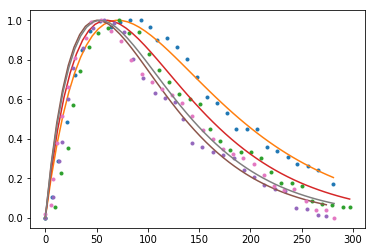

In [582]:
#-------------------------------------------------------------------------------------------------------------------------
# Estimation of vasoconstriction rates from Mulligan and McVicar (Nature 2004)
#-------------------------------------------------------------------------------------------------------------------------
# Generate traces
nsets = 4
filename = ['Mulligan_Nature2004_'] * nsets
traces = [None] * nsets
for i in range(nsets):
    traces[i] = numpy.loadtxt(open(data_dir+filename[i]+'cons'+str(i)+'.csv', "rb"), delimiter=",").T
    # Sorting by ascending x values
    idx = traces[i][0].argsort()
    traces[i][0] = traces[i][0][idx]
    traces[i][1] = -traces[i][1][idx]
    traces[i] = align(traces[i])
    
# # Intermediate check of data
# for i,tr in enumerate(traces):
#     plot(tr[0],normalize(tr[1]),'-') 

trise,tdecay,rate = np.zeros(len(traces)),np.zeros(len(traces)),np.zeros(len(traces))
for i,tr in enumerate(traces):
    s = itp.UnivariateSpline(tr[0],tr[1],s=0.,k=1)
    time = np.linspace(tr[0,0],tr[0,-1],npts)
    data = normalize(s(time))
    # Estimate rise and decay times
    bounds = ((40.,80.),(40.,80.))
    sol = opt.differential_evolution(objective,bounds=bounds,
                                     args=(time,data),tol=1e-5,popsize=400,strategy='rand1bin')
    rate[i] = biexp_linear(sol.x[0],sol.x[1],np.amax(tr[1]))
    print "[t_r,t_d,rate] : ",sol.x,rate[i],sol.success,sol.message
    if sol.success:
        trise[i]  = sol.x[0]
        tdecay[i] = sol.x[1]
    # Check results
    plot(tr[0],normalize(tr[1]),'.',
         time,bi_exp(time,sol.x[0],sol.x[1]),'-')

print "t_rise: ",np.round(np.mean(trise),ndec),"+/-",np.round(np.std(trise),ndec),"\trange: ",np.round(np.amin(trise),ndec),np.round(np.amax(trise),ndec)
print "t_decay: ",np.round(np.mean(tdecay),ndec),"+/-",np.round(np.std(tdecay),ndec),"\trange: ",np.round(np.amin(tdecay),ndec),np.round(np.amax(tdecay),ndec)
print "linear rate: ",np.round(np.mean(rate),ndec),"+/-",np.round(np.std(rate),ndec),"\trange: ",np.round(np.amin(rate),ndec),np.round(np.amax(rate),ndec)

[xmax,rate] :  [ 9.97275226  1.18403882] True Optimization terminated successfully.
[xmax,rate] :  [ 10.92696233   1.47579203] True Optimization terminated successfully.
[xmax,rate] :  [ 14.           0.25226947] True Optimization terminated successfully.
rate:  1.0 +/- 0.5 	range:  0.3 1.5
linear rate:  10.5 +/- 5.2 	range:  3.5 16.1


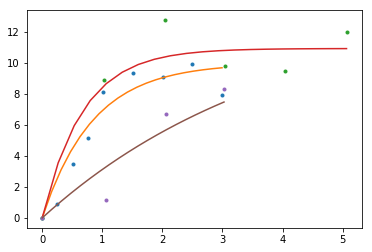

In [590]:
#-------------------------------------------------------------------------------------------------------------------------
# Estimation of vasodilation rates from Zonta et al. (Nature Neurosci. 2003)
#-------------------------------------------------------------------------------------------------------------------------
# Generate traces
nsets = 3
filename = ['Zonta_NN2003_'] * nsets
traces = [None] * nsets
for i in range(nsets):
    traces[i] = numpy.loadtxt(open(data_dir+filename[i]+'dilat'+str(i)+'.csv', "rb"), delimiter=",").T
    # Sorting by ascending x values
    idx = traces[i][0].argsort()
    traces[i][0] = traces[i][0][idx]
    traces[i][1] = traces[i][1][idx]
    traces[i] = align(traces[i])
    
# # Intermediate check of data
# for i,tr in enumerate(traces):
#     plot(tr[0],tr[1],'-') 

npts = 20
xmax,rate,pervar = np.zeros(len(traces)),np.zeros(len(traces)),np.zeros(len(traces))
for i,tr in enumerate(traces):
    s = itp.UnivariateSpline(tr[0],tr[1],s=0.,k=1)
    time = np.linspace(tr[0,0],tr[0,-1],npts)
    data = s(time)
    # Estimate rise and decay times
    bounds = ((5.,14.),(0.1,5.))
    sol = opt.differential_evolution(objective_exp,bounds=bounds,
                                     args=(time,data),tol=1e-4,popsize=300,strategy='rand1bin')
    rate[i] = biexp_linear(sol.x[0],sol.x[1],np.amax(tr[1]))
    print "[xmax,rate] : ",sol.x,sol.success,sol.message
    if sol.success:
        xmax[i]  = sol.x[0]
        rate[i] = sol.x[1]
        pervar[i] = xmax[i]*rate[i]
    # Check results
    plot(tr[0],tr[1],'.',
         time,exp_fun(time,sol.x[0],sol.x[1]),'-')

print "rate: ",np.round(np.mean(rate),ndec),"+/-",np.round(np.std(rate),ndec),"\trange: ",np.round(np.amin(rate),ndec),np.round(np.amax(rate),ndec)
print "linear rate: ",np.round(np.mean(pervar),ndec),"+/-",np.round(np.std(pervar),ndec),"\trange: ",np.round(np.amin(pervar),ndec),np.round(np.amax(pervar),ndec)